# Time-based Features and Moving Averages
## LSTM using Recursive Approach (7.4 from report)
### Per Day Analysis

Anastasios Koutsogiannopoulos, 03321

Fani Banou, 03322

Ioannis Sakellariou, 03144

This notebook preprocesses Bitcoin data by converting timestamps, resampling it to daily intervals, and engineering time-based and cyclic features (including moving averages).

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

### Utility Functions

In [2]:
def add_time_features(df):
    """
    Add time-based features to the DataFrame.
    Features include day, weekday, month, and a weekend indicator.
    """
    df['day'] = df.index.day
    df['weekday'] = df.index.weekday
    df['month'] = df.index.month
    df['is_weekend'] = df['weekday'].apply(lambda x: 1 if x >= 5 else 0)
    return df

In [3]:
def add_cyclic_features(df):
    """
    Add cyclic sine and cosine representations for time-related features:
    weekday, and month.
    """
    # Cyclic features for weekday
    df['weekday_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
    df['weekday_cos'] = np.cos(2 * np.pi * df['weekday'] / 7)
    # Cyclic features for month
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    return df

In [4]:
def load_and_preprocess_data(file_path):
    """
    Load CSV data, convert the unix timestamp to datetime, resample to daily frequency,
    add time-based and cyclic features, compute moving averages, and drop NaN values.
    """
    # Load the CSV data
    data = pd.read_csv(file_path)

    # Convert unix timestamp to datetime and set it as the index
    data['date'] = pd.to_datetime(data['unix'], unit='s')
    data.set_index('date', inplace=True)
    data = data.sort_index(ascending=True)

    # Keep only numeric columns
    numeric_data = data.select_dtypes(include=['float64', 'int64'])

    # Resample data to dialy frequency, mean values
    data_dialy = numeric_data.resample('1d').mean()

    # Add time-based features and cyclic representations
    data_dialy = add_time_features(data_dialy)
    data_dialy = add_cyclic_features(data_dialy)

    # Compute moving averages, MA_5 and MA_24
    data_dialy['MA_5'] = data_dialy['close'].rolling(window=5).mean()
    data_dialy['MA_24'] = data_dialy['close'].rolling(window=24).mean()

    # Drop rows with missing values
    data_dialy.dropna(inplace=True)
    return data_dialy

In [5]:
def split_data(data, train_end_date, test_start_date, test_end_date, feature_columns, target_column):
    """
    Split the data into training and testing sets based on the specified date ranges.
    Only the selected feature columns and target column are retained.
    """
    train_data = data[:train_end_date]
    test_data = data[test_start_date:test_end_date]
    train_data = train_data[feature_columns + [target_column]]
    test_data = test_data[feature_columns + [target_column]]
    return train_data, test_data

In [6]:
def scale_data(train_data, test_data):
    """
    Scale the training and testing data using MinMaxScaler.
    """
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_data)
    test_scaled = scaler.transform(test_data)
    return train_scaled, test_scaled, scaler

In [7]:
def create_sequences(features, target, sequence_length):
    """
    Create sequences of features and corresponding targets for time series forecasting.
    Each sequence is of length 'sequence_length', and the target is the value following the sequence.
    """
    x, y = [], []
    for i in range(len(features) - sequence_length):
        x.append(features[i:i + sequence_length])
        y.append(target[i + sequence_length])
    return np.array(x), np.array(y)

### Model Building Functions

In [8]:
def build_lstm_model(sequence_length, num_features):
    """
    Build an optimized LSTM model for time series forecasting.
    """
    model = Sequential([
      LSTM(128, return_sequences=True, input_shape=(sequence_length, num_features)),
      BatchNormalization(),
      Dropout(0.2),
      LSTM(128, return_sequences=True),
      BatchNormalization(),
      Dropout(0.2),
      LSTM(128, return_sequences=False),
      BatchNormalization(),
      Dropout(0.2),
      Dense(64, activation='relu'),
      Dropout(0.2),
      Dense(1)
  ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error'])

    return model

In [9]:
def train_model(model, x_train, y_train, batch_size=256, epochs=100, validation_split=0.2, patience=20):
    """
    Train the model using early stopping to prevent overfitting.
    """

    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    history = model.fit(
        x_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=validation_split,
        shuffle=False,
        callbacks=[early_stopping]
    )

    return history

### Prediction and Evaluation Functions

In [10]:
def predict_test(model, train_scaled, test_scaled, sequence_length, feature_columns, scaler, test_data):
    """
    Generate predictions for the test set using an iterative approach.
    The input sequence is updated with the predicted value and new moving averages are computed.
    """
    # Remove 'MA_5', 'MA_24', and 'close' from test_scaled to retain only time features
    test_scaled_filtered = np.delete(test_scaled, [0, 1, -1], axis=1)

    # Get the last 24 scaled 'close' values from training data last column
    last_close_values = train_scaled[-24:, -1].tolist()

    # Initialize the input sequence with the last sequence_length entries excluding 'close'
    input_sequence = train_scaled[-sequence_length:, :-1].tolist()

    predictions = []

    # Iteratively predict each time step in the test set
    for i in range(len(test_scaled_filtered)):
        # Prepare the input sequence for prediction
        x_input = np.array(input_sequence).reshape(1, sequence_length, len(feature_columns))
        # Predict the next scaled close value
        predicted_value_scaled = model.predict(x_input, verbose=0)[0, 0]
        predictions.append(predicted_value_scaled)

        # Update the close values list with the new prediction
        last_close_values.append(predicted_value_scaled)
        last_close_values.pop(0)

        # Compute moving averages from the updated close values
        ma_5 = np.mean(last_close_values[-5:])
        ma_24 = np.mean(last_close_values[-24:])

        # Retrieve the already scaled time features for the current test time step
        time_features_scaled = test_scaled_filtered[i]

        # Create the new input feature vector with updated moving averages and time features
        next_input_scaled = np.concatenate([[ma_5, ma_24], time_features_scaled])

        # Update the input sequence window for the next prediction
        input_sequence.append(next_input_scaled)
        input_sequence.pop(0)

    # Inverse transform the predictions to obtain the original scale
    predicted_close_unscaled = scaler.inverse_transform(
        np.concatenate([test_scaled[:, :-1], np.array(predictions).reshape(-1, 1)], axis=1)
    )[:, -1]

    return predicted_close_unscaled, predictions

In [11]:
def plot_training_history(history):
    """
    Plot the training and validation loss over epochs.
    """
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss vs Validation Loss')
    plt.show()

In [12]:
def plot_predictions(test_data, actual_close, predicted_close_unscaled):
    """
    Plot the actual vs predicted close prices.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(test_data.index, actual_close, label="Actual Close", color='blue', linestyle='dashed')
    plt.plot(test_data.index, predicted_close_unscaled, label="Predicted Close", color='red')
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.title("Comparison of Actual vs Predicted Close Prices")
    plt.legend()
    plt.grid(True)
    plt.show()

In [13]:
def evaluate_predictions(actual_close, predicted_close_unscaled):
    """
    Evaluate the predictions using common regression metrics.
    """
    mae = mean_absolute_error(actual_close, predicted_close_unscaled)
    mse = mean_squared_error(actual_close, predicted_close_unscaled)
    rmse = np.sqrt(mse)

    print("Mean Absolute Error (MAE):", mae)
    print("Mean Squared Error (MSE):", mse)
    print("Root Mean Squared Error (RMSE):", rmse)

In [14]:
def run_multiple_experiments(x_train, y_train, train_scaled, test_scaled, sequence_length,
                             feature_columns, scaler, test_data, num_runs=10):
    """
    Runs the training, prediction, and evaluation process num_runs times,
    then computes and plots the average training/validation loss curves and
    the average predicted close price against the actual values.
    """
    training_histories = []  # To store the training history for each run
    predicted_runs = []      # To store the predicted close values for each run
    metrics_list = []        # To store the evaluation metrics for each run
    train_times = []         # To store execution times for model training
    predict_times = []      # To store execution times for predict

    # Get actual close values from the test data once
    actual_close = test_data['close'].values

    for run in range(num_runs):
        print(f"Run {run+1}/{num_runs}")
        # Build the LSTM model
        model = build_lstm_model(sequence_length, len(feature_columns))
        # Train the model
        start_time = time.time()
        history = train_model(model, x_train, y_train)
        train_time = time.time() - start_time
        train_times.append(train_time)

        training_histories.append(history)
        # Generate predictions for the test set
        start_time = time.time()
        predicted_close_unscaled, _ = predict_test(model, train_scaled, test_scaled,
                                                   sequence_length, feature_columns, scaler, test_data)
        predict_time = time.time() - start_time
        predict_times.append(predict_time)

        predicted_runs.append(predicted_close_unscaled)
        # Calculate evaluation metrics
        mae = mean_absolute_error(actual_close, predicted_close_unscaled)
        mse = mean_squared_error(actual_close, predicted_close_unscaled)
        rmse = np.sqrt(mse)
        metrics_list.append({'MAE': mae, 'MSE': mse, 'RMSE': rmse})

    # Determine the minimum number of epochs among all runs due to early stopping, these may vary
    min_epochs = min(len(hist.history['loss']) for hist in training_histories if 'loss' in hist.history)
    # Average the training and validation loss curves over the minimum number of epochs
    avg_loss = np.mean([hist.history['loss'][:min_epochs] for hist in training_histories if 'loss' in hist.history], axis=0)
    avg_val_loss = np.mean([hist.history['val_loss'][:min_epochs] for hist in training_histories if 'val_loss' in hist.history], axis=0)

    # Plot the average training history
    plt.figure(figsize=(8, 5))
    epochs_range = range(1, min_epochs+1)
    plt.plot(epochs_range, avg_loss, label='Average Training Loss')
    plt.plot(epochs_range, avg_val_loss, label='Average Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Average Training & Validation Loss over {num_runs} Runs")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Compute the average predicted close prices across runs
    avg_predicted_close = np.mean(np.array(predicted_runs), axis=0)

    # Plot the actual close vs. average predicted close
    plot_predictions(test_data, actual_close, avg_predicted_close)

    # Average the evaluation metrics over all runs
    avg_metrics = {
         'MAE': np.mean([m['MAE'] for m in metrics_list]),
         'MSE': np.mean([m['MSE'] for m in metrics_list]),
         'RMSE': np.mean([m['RMSE'] for m in metrics_list])
    }
    print(f"Average Metrics over {num_runs} Runs:")
    print("Mean Absolute Error (MAE):", avg_metrics['MAE'])
    print("Mean Squared Error (MSE):", avg_metrics['MSE'])
    print("Root Mean Squared Error (RMSE):", avg_metrics['RMSE'])

    # Compute and print average execution times
    avg_train_time = np.mean(train_times)
    avg_predict_time = np.mean(predict_times)
    print(f"\nAverage Execution Times over {num_runs} Runs:")
    print(f"Model Training Time: {avg_train_time:.4f} seconds")
    print(f"Predicting Time: {avg_predict_time:.4f} seconds")


### Main Function

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
x_train shape: (377, 14, 6)
Run 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 504ms/step - loss: 1.8413 - mean_absolute_error: 1.0699 - val_loss: 0.1054 - val_mean_absolute_error: 0.3055
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 3.5930 - mean_absolute_error: 1.5309 - val_loss: 0.0830 - val_mean_absolute_error: 0.2690
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 1.2548 - mean_absolute_error: 0.8752 - val_loss: 0.0899 - val_mean_absolute_error: 0.2817
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 1.1917 - mean_absolute_error: 0.8684 - val_loss: 0.0926 - val_mean_absolute_error: 0.2867
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.8802 - mean_absolute_error: 0.7534 - val_loss: 0.0889 - val_mean_absolute_error: 0.2805
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.8850 - mean_absolute_error: 0.7565 - val_loss: 0.0837 - val_mean_absolute_error: 0.2711
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.8228 - mean_absolute_error: 0.7142 - val_loss: 0.07

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 517ms/step - loss: 2.2806 - mean_absolute_error: 1.2709 - val_loss: 0.1387 - val_mean_absolute_error: 0.3536
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 1.4736 - mean_absolute_error: 0.9330 - val_loss: 0.1123 - val_mean_absolute_error: 0.3124
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.7945 - mean_absolute_error: 0.7172 - val_loss: 0.1056 - val_mean_absolute_error: 0.3025
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.7531 - mean_absolute_error: 0.7147 - val_loss: 0.0977 - val_mean_absolute_error: 0.2894
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.6714 - mean_absolute_error: 0.6553 - val_loss: 0.0880 - val_mean_absolute_error: 0.2732
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.7996 - mean_absolute_error: 0.7064 - val_loss: 0.0815 - val_mean_absolute_error: 0.2621
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.5408 - mean_absolute_error: 0.5911 - val_loss: 0.0791 - val_me

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 829ms/step - loss: 3.9794 - mean_absolute_error: 1.6450 - val_loss: 0.1270 - val_mean_absolute_error: 0.3339
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 1.9861 - mean_absolute_error: 1.1497 - val_loss: 0.1123 - val_mean_absolute_error: 0.3116
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.7347 - mean_absolute_error: 0.6861 - val_loss: 0.0950 - val_mean_absolute_error: 0.2824
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.8881 - mean_absolute_error: 0.7471 - val_loss: 0.0817 - val_mean_absolute_error: 0.2573
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.7984 - mean_absolute_error: 0.7141 - val_loss: 0.0769 - val_mean_absolute_error: 0.2474
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.7157 - mean_absolute_error: 0.6587 - val_loss: 0.0765 - val_mean_absolute_error: 0.2463
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.6815 - mean_absolute_error: 0.6659 - val_loss: 0.0773 - val_me

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 535ms/step - loss: 1.1038 - mean_absolute_error: 0.8463 - val_loss: 0.1583 - val_mean_absolute_error: 0.3780
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 1.7598 - mean_absolute_error: 1.0784 - val_loss: 0.1596 - val_mean_absolute_error: 0.3796
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 1.1625 - mean_absolute_error: 0.8606 - val_loss: 0.1659 - val_mean_absolute_error: 0.3870
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.9647 - mean_absolute_error: 0.8062 - val_loss: 0.1404 - val_mean_absolute_error: 0.3542
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.7573 - mean_absolute_error: 0.6907 - val_loss: 0.1170 - val_mean_absolute_error: 0.3212
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.8416 - mean_absolute_error: 0.7349 - val_loss: 0.1023 - val_mean_absolute_error: 0.2982
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.7587 - mean_absolute_error: 0.7020 - val_loss: 0.0948 - val_me

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 502ms/step - loss: 4.0885 - mean_absolute_error: 1.7161 - val_loss: 0.1479 - val_mean_absolute_error: 0.3675
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 2.6247 - mean_absolute_error: 1.2566 - val_loss: 0.1719 - val_mean_absolute_error: 0.3985
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 1.0621 - mean_absolute_error: 0.8092 - val_loss: 0.1689 - val_mean_absolute_error: 0.3946
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 1.0312 - mean_absolute_error: 0.8122 - val_loss: 0.1652 - val_mean_absolute_error: 0.3900
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.9734 - mean_absolute_error: 0.7838 - val_loss: 0.1674 - val_mean_absolute_error: 0.3934
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.7278 - mean_absolute_error: 0.6834 - val_loss: 0.1705 - val_mean_absolute_error: 0.3982
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.7484 - mean_absolute_error: 0.6770 - val_loss: 0.1695 - val_mea

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 565ms/step - loss: 2.9854 - mean_absolute_error: 1.3641 - val_loss: 0.1244 - val_mean_absolute_error: 0.3376
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 4.7758 - mean_absolute_error: 1.7650 - val_loss: 0.0794 - val_mean_absolute_error: 0.2602
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 1.0255 - mean_absolute_error: 0.7808 - val_loss: 0.0589 - val_mean_absolute_error: 0.2164
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 1.0430 - mean_absolute_error: 0.8219 - val_loss: 0.0544 - val_mean_absolute_error: 0.2056
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.7964 - mean_absolute_error: 0.7173 - val_loss: 0.0537 - val_mean_absolute_error: 0.2039
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.9654 - mean_absolute_error: 0.7903 - val_loss: 0.0492 - val_mean_absolute_error: 0.1940
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.8228 - mean_absolute_error: 0.6996 - val_loss: 0.0434 - val_me

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 521ms/step - loss: 1.9664 - mean_absolute_error: 1.1418 - val_loss: 0.1115 - val_mean_absolute_error: 0.3110
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 2.1946 - mean_absolute_error: 1.2018 - val_loss: 0.1332 - val_mean_absolute_error: 0.3451
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 1.0017 - mean_absolute_error: 0.7939 - val_loss: 0.1324 - val_mean_absolute_error: 0.3435
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.9268 - mean_absolute_error: 0.7908 - val_loss: 0.1337 - val_mean_absolute_error: 0.3451
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.8795 - mean_absolute_error: 0.7612 - val_loss: 0.1400 - val_mean_absolute_error: 0.3542
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.7740 - mean_absolute_error: 0.6876 - val_loss: 0.1323 - val_mean_absolute_error: 0.3435
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.8315 - mean_absolute_error: 0.7198 - val_loss: 0.1049 - val_mea

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 548ms/step - loss: 2.2073 - mean_absolute_error: 1.1770 - val_loss: 0.1216 - val_mean_absolute_error: 0.3322
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 3.0448 - mean_absolute_error: 1.3734 - val_loss: 0.1100 - val_mean_absolute_error: 0.3134
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 1.0581 - mean_absolute_error: 0.8183 - val_loss: 0.1043 - val_mean_absolute_error: 0.3039
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.7019 - mean_absolute_error: 0.6626 - val_loss: 0.1030 - val_mean_absolute_error: 0.3016
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.6990 - mean_absolute_error: 0.6783 - val_loss: 0.1041 - val_mean_absolute_error: 0.3034
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.6238 - mean_absolute_error: 0.6503 - val_loss: 0.1032 - val_mean_absolute_error: 0.3018
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.5742 - mean_absolute_error: 0.5940 - val_loss: 0.0985 - val_mea

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 500ms/step - loss: 1.1065 - mean_absolute_error: 0.8681 - val_loss: 0.0954 - val_mean_absolute_error: 0.2855
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 2.4852 - mean_absolute_error: 1.3196 - val_loss: 0.1037 - val_mean_absolute_error: 0.3027
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.7778 - mean_absolute_error: 0.6855 - val_loss: 0.1055 - val_mean_absolute_error: 0.3063
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 1.2309 - mean_absolute_error: 0.8842 - val_loss: 0.1025 - val_mean_absolute_error: 0.3022
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.8431 - mean_absolute_error: 0.7253 - val_loss: 0.0996 - val_mean_absolute_error: 0.2981
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.7096 - mean_absolute_error: 0.6497 - val_loss: 0.0994 - val_mean_absolute_error: 0.2975
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.6497 - mean_absolute_error: 0.6394 - val_loss: 0.1005 - val_me

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 503ms/step - loss: 2.0956 - mean_absolute_error: 1.1591 - val_loss: 0.1233 - val_mean_absolute_error: 0.3328
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 1.7732 - mean_absolute_error: 1.0443 - val_loss: 0.1166 - val_mean_absolute_error: 0.3222
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 1.6126 - mean_absolute_error: 1.0058 - val_loss: 0.1007 - val_mean_absolute_error: 0.2977
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 1.1872 - mean_absolute_error: 0.8508 - val_loss: 0.0910 - val_mean_absolute_error: 0.2817
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 1.2908 - mean_absolute_error: 0.9097 - val_loss: 0.0866 - val_mean_absolute_error: 0.2747
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.8107 - mean_absolute_error: 0.7175 - val_loss: 0.0849 - val_mean_absolute_error: 0.2717
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 1.0509 - mean_absolute_error: 0.8255 - val_loss: 0.0807 - val_mea

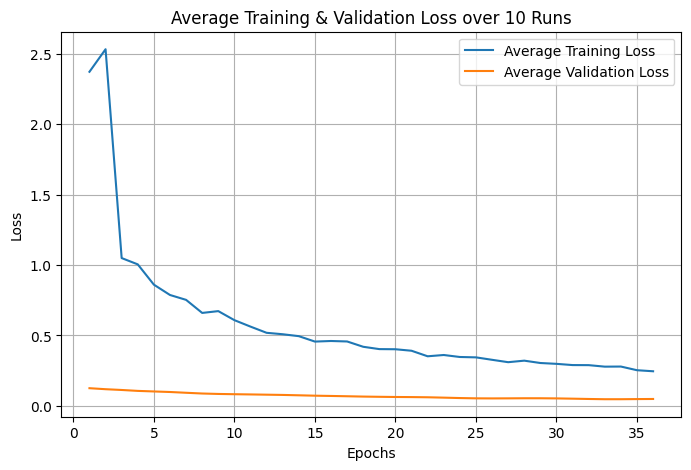

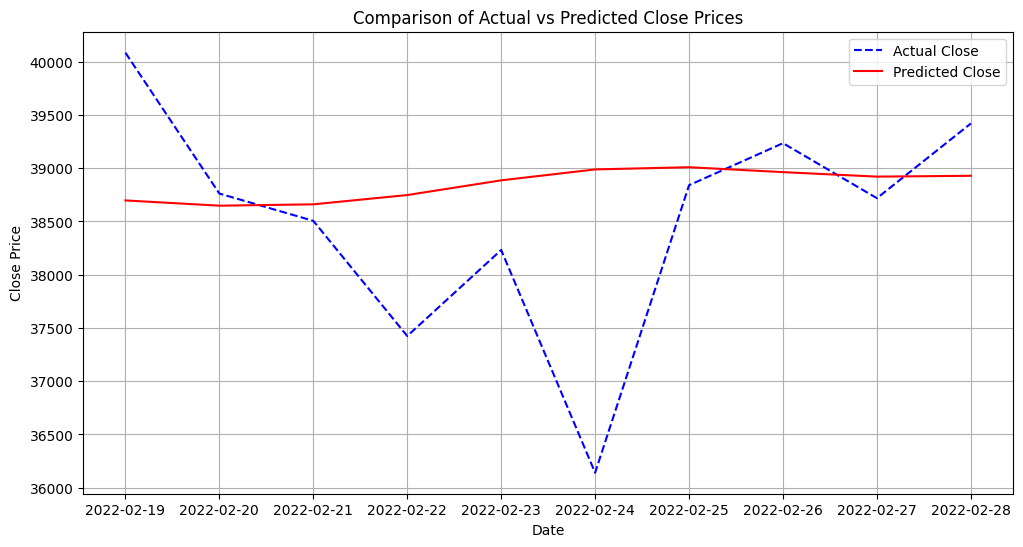

Average Metrics over 10 Runs:
Mean Absolute Error (MAE): 2199.7086105186927
Mean Squared Error (MSE): 6709750.27275156
Root Mean Squared Error (RMSE): 2434.7025804283826

Average Execution Times over 10 Runs:
Model Training Time: 17.1030 seconds
Predicting Time: 1.0748 seconds


In [17]:
def main():
    # Mount Google Drive
    try:
        from google.colab import drive
        drive.mount('/content/drive/')
    except ImportError:
        print("Not running on Google Colab; skipping drive mount.")

    # File path for the dataset
    file_path = "/content/drive/MyDrive/bitcoin-dataset.csv"

    # Load and preprocess the dataset
    data_dialy = load_and_preprocess_data(file_path)

    # Define date ranges for training and testing
    train_end_date = '2022-02-18 23:59:59'
    test_start_date = '2022-02-19 00:00:00'
    test_end_date = '2022-02-28 23:59:59'

    # Define the feature columns and the target column
    feature_columns = ['MA_5', 'MA_24',
                       'weekday_sin', 'weekday_cos', 'month_sin', 'month_cos']
    target_column = 'close'

    # Split the data into training and testing sets
    train_data, test_data = split_data(data_dialy, train_end_date, test_start_date, test_end_date,
                                       feature_columns, target_column)

    # Scale the data
    train_scaled, test_scaled, scaler = scale_data(train_data, test_data)

    # Create sequences for training
    sequence_length = 14
    x_train, y_train = create_sequences(train_scaled[:, :-1], train_scaled[:, -1], sequence_length)
    print("x_train shape:", x_train.shape)

    # # Build and train the optimized LSTM model
    # model_lstm = build_lstm_model(sequence_length, len(feature_columns))
    # history = train_model(model_lstm, x_train, y_train)

    # # Plot training history
    # plot_training_history(history)

    # # Generate predictions on the test set using the trained model
    # predicted_close_unscaled, _ = predict_test(model_lstm, train_scaled, test_scaled,
    #                                            sequence_length, feature_columns, scaler, test_data)

    # # Retrieve the actual close prices from the test data
    # actual_close = test_data['close'].values

    # # Plot the actual vs predicted close prices
    # plot_predictions(test_data, actual_close, predicted_close_unscaled)

    # # Evaluate the predictions using standard metrics
    # evaluate_predictions(actual_close, predicted_close_unscaled)

    # Run the experiment 10 times and plot/print the averaged results
    run_multiple_experiments(x_train, y_train, train_scaled, test_scaled, sequence_length,
                             feature_columns, scaler, test_data, num_runs=10)

if __name__ == "__main__":
    main()